#  <font color='red'>Table of Contents</font>

[2. Data Processing](#section2)<br>
[3. Feature Engineering](#section3)<br>
[4. Collinearity Matrix](#section4)<br>

In [1]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# DL Libs..

CWD is  C:\Users\demitra\Downloads\mercari


C:\Users\demitra\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\demitra\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  <a id = 'section2'> <font color='red'>  2. Data Processing  </font> </a>

### <font color='red'> 2.1 Train Test Split </font>

In [5]:
df_train = pd.read_csv('train.tsv',sep = '\t')
df_train_model,df_test_model = train_test_split(df_train,test_size = 0.25)
print(df_train_model.shape,df_test_model.shape)

(1111901, 8) (370634, 8)


In [6]:
#ref - https://www.journaldev.com/15638/python-pickle-example
'''
file = open('df_train_model', 'wb')
pickle.dump(df_train_model, file)
file.close()

file = open('df_test_model', 'wb')
pickle.dump(df_test_model, file)
file.close()
'''

In [2]:

file = open('df_train_model', 'rb')
df_train_model = pickle.load(file)
file.close()

file = open('df_test_model', 'rb')
df_test_model = pickle.load(file)
file.close()

print(df_train_model.shape,df_test_model.shape)

(1111901, 8) (370634, 8)


### <font color='red'> 2.2 Data Cleaning </font>

In [4]:
# ref - https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755

df_train_model = df_train_model[(df_train_model.price >= 3) & (df_train_model.price <= 2000)]
print(df_train_model.shape)

(1111222, 8)


##### Summary - Mercari's app platform only allows product listings between 3 and 2000 as per kaggle kernel above, we shall filter data accordingly

### <font color='red'> 2.3 Text Preprocess  </font>

In [6]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def text_preprocess(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentance in tqdm_notebook(data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [7]:
df_train_model['name'] = df_train_model['name'].replace([np.nan], '')
df_test_model['name'] = df_test_model['name'].replace([np.nan], '')

df_train_model['item_description'] = df_train_model['item_description'].replace([np.nan,'No description yet'], '')
df_test_model['item_description'] = df_test_model['item_description'].replace([np.nan,'No description yet'], '')

In [8]:
df_train_model['preprocessed_names'] = text_preprocess(df_train_model['name'])
df_test_model['preprocessed_names'] = text_preprocess(df_test_model['name'])

df_train_model['preprocessed_desc'] = text_preprocess(df_train_model['item_description'])
df_test_model['preprocessed_desc'] = text_preprocess(df_test_model['item_description'])

### <font color='red'> 2.4 Feature Transform - Text Data  </font>

In [9]:
def text_encoder(train,test,vect_type,params):
    vectorizer = CountVectorizer(ngram_range = params[0],
                                 min_df = params[1],
                                 max_df = params[2],
                                 max_features = params[3]) if vect_type == 'BOW' else TfidfVectorizer(ngram_range = params[0],
                                                                                                      min_df = params[1],
                                                                                                      max_df = params[2],
                                                                                                      max_features = params[3])
    train_transform = vectorizer.fit_transform(train)
    test_transform = vectorizer.transform(test)
    feat_names = vectorizer.get_feature_names()
    return train_transform,test_transform,feat_names

In [10]:
# Input params = [ngram, min_df,max_df,max_features]

train_bow_name,test_bow_name,name_feats = text_encoder(df_train_model['preprocessed_names'],
                                                      df_test_model['preprocessed_names'],
                                                      'BOW',
                                                      ((1,4),25,1.0,50000))

train_bow_desc,test_bow_desc,desc_feats = text_encoder(df_train_model['preprocessed_desc'],
                                                       df_test_model['preprocessed_desc'],
                                                       'BOW',
                                                       ((1,3),30,1.0,100000))

In [11]:
print(train_bow_name.shape,test_bow_name.shape)
print(train_bow_desc.shape,test_bow_desc.shape)

(1111222, 31782) (370634, 31782)
(1111222, 100000) (370634, 100000)


In [12]:
'''file = open('train_bow_name', 'wb')
pickle.dump(train_bow_name, file)
file.close()

file = open('test_bow_name', 'wb')
pickle.dump(test_bow_name, file)
file.close()

file = open('train_bow_desc', 'wb')
pickle.dump(train_bow_desc, file)
file.close()

file = open('test_bow_desc', 'wb')
pickle.dump(test_bow_desc, file)
file.close()'''

### <font color='red'> 2.4 Feature Transform - Categorical Features (Brand,Category,Shipping,Item Condition)  </font>

In [13]:
def brand_encoder(train,test):
    vect = LabelBinarizer(sparse_output=True)
    train_transform = vect.fit_transform(train["brand_name"])
    test_transform = vect.transform(test["brand_name"])
    return train_transform,test_transform

df_train_model["brand_name"] = df_train_model["brand_name"].fillna("missing").astype("category")
df_test_model["brand_name"] = df_test_model["brand_name"].fillna("missing").astype("category")
train_brand,test_brand = brand_encoder(df_train_model,df_test_model)
print(train_brand.shape,test_brand.shape)

(1111222, 4445) (370634, 4445)


In [14]:
'''file = open('train_brand', 'wb')
pickle.dump(train_brand, file)
file.close()

file = open('test_brand', 'wb')
pickle.dump(test_brand, file)
file.close()'''

In [15]:
def category_encoder(train,test):
    unique_categories = pd.Series("/".join(train["category_name"].unique().astype("str")).split("/")).unique()
    count_category = CountVectorizer(vocabulary = unique_categories,lowercase = False,binary = True)
    train_transform = count_category.fit_transform(train["category_name"])
    test_transform = count_category.transform(test['category_name'])
    return train_transform,test_transform

df_train_model["category_name"] = df_train_model["category_name"].fillna("missing").astype("category")
df_test_model["category_name"] = df_test_model["category_name"].fillna("missing").astype("category")
train_category,test_category = category_encoder(df_train_model,df_test_model)
print(train_category.shape,test_category.shape)

(1111222, 932) (370634, 932)


In [16]:
'''file = open('train_category', 'wb')
pickle.dump(train_category, file)
file.close()

file = open('test_category', 'wb')
pickle.dump(test_category, file)
file.close()'''

In [17]:
def dummy_encoder(train,test):
    train_transform = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", 
                                                                         "shipping"]], sparse = True).values)
    test_transform = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id", 
                                                                         "shipping"]], sparse = True).values)
    return train_transform,test_transform

df_train_model["shipping"] = df_train_model["shipping"].astype("category")
df_test_model["shipping"] = df_test_model["shipping"].astype("category")
df_train_model["item_condition_id"] = df_train_model["item_condition_id"].astype("category")
df_test_model["item_condition_id"] = df_test_model["item_condition_id"].astype("category")
train_dummies,test_dummies = dummy_encoder(df_train_model,df_test_model)
print(train_dummies.shape,test_dummies.shape)

(1111222, 7) (370634, 7)


In [18]:
'''file = open('train_dummies', 'wb')
pickle.dump(train_dummies, file)
file.close()

file = open('test_dummies', 'wb')
pickle.dump(test_dummies, file)
file.close()'''

### <font color='red'> 2.5 Feature Log Transform - Price </font>

In [19]:
df_train_model['log_price'] = np.log1p(df_train_model['price'])
df_test_model['log_price'] = np.log1p(df_test_model['price'])

#  <a id = 'section3'> <font color='red'>  3. Feature Engineering  </font> </a>

### <font color='red'> 3.1 Text Features - 'Item Description' - 7 new Features </font>

In [20]:
#ref - https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th

print('Generating features with statistics for item description textual content')

acronyms_regex = re.compile('([A-Z\-0-9]{2,})')
hashtag_regex = re.compile(r'(#[a-z]{2,})')

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

#Extracts statistics for each description, words lengths, like percentage of upper-case words, hashtags, etc
def extract_counts(text):
    text_size_words_counts = len(text.split(' '))
    text_size_words_log_counts = math.log1p(text_size_words_counts)
    full_uppercase_perc = len(acronyms_regex.findall(text)) / float(text_size_words_counts)
    exclamation_log_count = math.log1p(text.count('!'))
    star_log_count = math.log1p(text.count('*'))
    percentage_log_count = math.log1p(text.count('%'))
    price_removed_marker_log_count = math.log1p(text.count('[rm]'))
    hashtag_log_count = math.log1p(len(hashtag_regex.findall(text)))
    return [text_size_words_log_counts,
            full_uppercase_perc,
            exclamation_log_count,
            star_log_count,            
            percentage_log_count,
            price_removed_marker_log_count,
            hashtag_log_count]

Generating features with statistics for item description textual content


In [21]:
item_descr_counts = np.vstack(df_train_model['item_description'].astype(str).apply(extract_counts).values)
item_descr_counts_scaler = StandardScaler(copy=True)
train_desc_feats = item_descr_counts_scaler.fit_transform(item_descr_counts)
print(train_desc_feats.shape)

(1111222, 7)


In [22]:
item_descr_counts = np.vstack(df_test_model['item_description'].astype(str).apply(extract_counts).values)
item_descr_counts_scaler = StandardScaler(copy=True)
test_desc_feats = item_descr_counts_scaler.fit_transform(item_descr_counts)
print(test_desc_feats.shape)

(370634, 7)


In [23]:
'''file = open('train_desc_feats', 'wb')
pickle.dump(train_desc_feats, file)
file.close()

file = open('test_desc_feats', 'wb')
pickle.dump(test_desc_feats, file)
file.close()'''

### <font color='red'> 3.2 Text Features - Sentiment Scores (Name,Description) - 4 new features </font>

In [26]:
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    scores = []
    for sentence in tqdm_notebook(data): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        scores.append(sentence_sentiment_score['compound'])
    return scores

In [27]:
train_senti_names = generate_sentiment_scores(df_train_model['preprocessed_names'])
df_train_model['senti_names'] = train_senti_names

test_senti_names = generate_sentiment_scores(df_test_model['preprocessed_names'])
df_test_model['senti_names'] = test_senti_names

In [28]:
'''file = open('train_senti_names', 'wb')
pickle.dump(train_senti_names, file)
file.close()

file = open('test_senti_names', 'wb')
pickle.dump(test_senti_names, file)
file.close()'''

In [29]:
train_senti_desc = generate_sentiment_scores(df_train_model['preprocessed_desc'])
df_train_model['senti_desc'] = train_senti_desc

test_senti_desc = generate_sentiment_scores(df_test_model['preprocessed_desc'])
df_test_model['senti_desc'] = test_senti_desc

In [30]:
'''file = open('train_senti_desc', 'wb')
pickle.dump(train_senti_desc, file)
file.close()

file = open('test_senti_desc', 'wb')
pickle.dump(test_senti_desc, file)
file.close()'''

### <font color='red'> 3.3 Grouped Price Statistics (Category,Brand,Shipping) - 8 new features </font>

In [31]:
def generate_cbs_stats(train,test):
    df_group = train.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "log_price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group.columns = ['cat_brand_ship','cbs_count','cbs_log_price_median','cbs_log_price_mean','cbs_log_price_std',
                    'cbs_log_price_min','cbs_log_price_max']

    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))
    
    df_group_stats = test.merge(df_group.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cbs_log_count',
                                                              'cbs_log_price_mean',
                                                              'cbs_log_price_std',
                                                              'cbs_log_price_conf_variance',
                                                              'cbs_min_expected_log_price',
                                                              'cbs_max_expected_log_price',
                                                              'cbs_log_price_min',
                                                              'cbs_log_price_max']].fillna(0).values
    
    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [32]:
df_train_model['cat_brand_ship'] = (df_train_model['category_name'].astype(str) + "_" + 
                                    df_train_model['brand_name'].astype(str) + "_" +  
                                    df_train_model['shipping'].astype(str))
df_test_model['cat_brand_ship'] = (df_test_model['category_name'].astype(str) + "_" + 
                                    df_test_model['brand_name'].astype(str) + "_" +  
                                    df_test_model['shipping'].astype(str))

In [33]:
train_cbs_feats = generate_cbs_stats(df_train_model,df_train_model)
test_cbs_feats = generate_cbs_stats(df_train_model,df_test_model)
print(train_cbs_feats.shape,test_cbs_feats.shape)

(1111222, 8) (370634, 8)


In [34]:
'''file = open('train_cbs_feats', 'wb')
pickle.dump(train_cbs_feats, file)
file.close()

file = open('test_cbs_feats', 'wb')
pickle.dump(test_cbs_feats, file)
file.close()'''

#  <a id = 'section4'> <font color='red'>  4. Collinearity Matrix  </font> </a>

In [111]:
df_corr = pd.concat([pd.DataFrame(train_desc_feats,
                                  columns = ['text_size_words_log_counts','full_uppercase_perc','exclamation_log_count',
                                             'star_log_count','percentage_log_count','price_removed_marker_log_count',
                                             'hashtag_log_count']),
                    pd.DataFrame(generate_cbs_stats(df_train_model,df_train_model),
                                  columns = ['cbs_log_count','cbs_log_price_mean','cbs_log_price_std',
                                             'cbs_log_price_conf_variance','cbs_min_expected_log_price',
                                             'cbs_max_expected_log_price','cbs_log_price_min','cbs_log_price_max']),
                    df_train_model[['senti_names','senti_desc']].reset_index(drop = True),
                    df_train_model['log_price'].reset_index(drop = True)],axis = 1)

In [112]:
df_corr.head(4)

,text_size_words_log_counts,full_uppercase_perc,exclamation_log_count,star_log_count,percentage_log_count,price_removed_marker_log_count,hashtag_log_count,cbs_log_count,cbs_log_price_mean,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max,senti_names,senti_desc,log_price
0,0.908917,-0.469012,0.842374,-0.202149,-0.215939,-0.287484,-0.060976,0.007672,1.582059,0.937429,0.039365,0.897940,1.660095,0.820352,0.627173,0.4939,0.6566,3.258097
1,-1.970379,-0.469012,-0.514064,-0.202149,-0.215939,-0.287484,-0.060976,0.044558,0.617213,-0.921444,-1.131196,1.180551,-0.005283,1.390901,0.091666,0.0000,0.0000,3.496508
2,0.357850,-0.469012,-0.514064,-0.202149,-0.215939,-0.287484,-0.060976,-0.814208,0.379433,0.030190,-0.197696,0.333744,0.299414,-0.290513,-0.473179,0.4767,0.7506,3.610918
3,1.188953,-0.223427,-0.514064,-0.202149,-0.215939,-0.287484,-0.060976,0.483217,1.962546,-0.361770,-1.048282,2.107630,1.285939,0.335093,0.459787,0.0000,-0.5750,4.007333


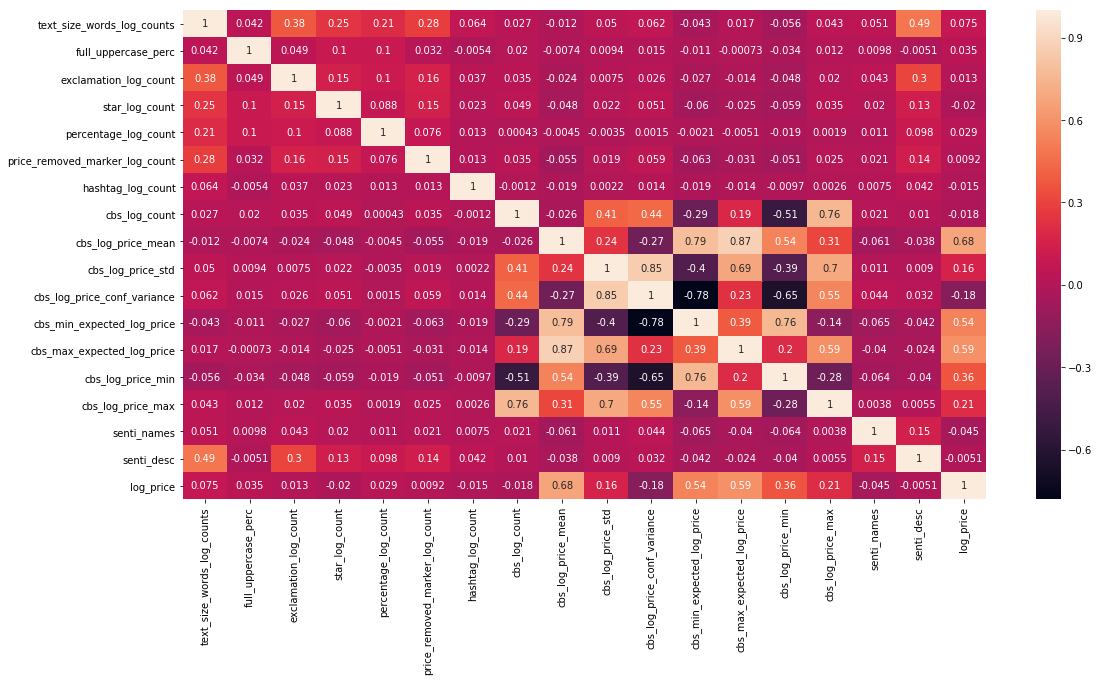

In [114]:
#ref = https://datatofish.com/correlation-matrix-pandas/
corrMatrix  = df_corr.corr()

plt.figure(figsize = (18,9))
sns.heatmap(corrMatrix, annot=True)
plt.show()